# Integrators and sampling

In [1]:
# Preliminary imports
from simtk import openmm, unit
from simtk.openmm import app
import numpy as np

To explore the integrators available for sampling in OpenMM, we'll use the alanine dipeptide in vacuum test system imported from [`openmmtools`](http://openmmtools.readthedocs.io):

In [2]:
# Create an alanine dipeptide in vacuum
from openmmtools import testsystems
t = testsystems.AlanineDipeptideVacuum()
system, positions, topology = t.system, t.positions, t.topology

## Integrators available for use

There are several ways to specify which integrators to use for sampling:
* Use one of the [built-in OpenMM integrators](http://docs.openmm.org/7.1.0/api-python/library.html#integrators)
* Use the powerful [`CustomIntegrator`](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.CustomIntegrator.html#simtk.openmm.openmm.CustomIntegrator) facility to define your own integrator in terms of basic algebraic operations on positions and velocities
* Use one of the high-quality integrators from [`openmmtools.integrators`](http://openmmtools.readthedocs.io/en/latest/integrators.html)
* Write your own integrator plugin using C++ (and CUDA or OpenCL)

## Built-in OpenMM integrators

OpenMM provides a number of built-in [`Integrators`](http://docs.openmm.org/7.1.0/userguide/application.html#integrators) that may be useful for your intended application, but also provides a very flexible way to efficiently define new integrators that can still be executed very efficiently on the GPU.

All OpenMM integrators are derived from the [`Integrator`](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.Integrator.html#simtk.openmm.openmm.Integrator) base class that provides some baseline functionality such that all integrators work the same way. 

OpenMM provides a [large number of integrators you can use directly](http://docs.openmm.org/7.1.0/api-python/library.html#integrators). Here are just a few of them:
* [`VerletIntegrator`](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.VerletIntegrator.html#simtk.openmm.openmm.VerletIntegrator): A leapfrog Verlet integrator where the positions and velocities are half a timestep out of sync. This is useful in many situations, but care must be taken regarding the half timestep lag.
* [`LangevinIntegrator`](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.LangevinIntegrator.html#simtk.openmm.openmm.LangevinIntegrator): A [leapfrog Langevin](https://github.com/pandegroup/openmm/issues/1766#issuecomment-289615072) / [VVVR](http://dx.doi.org/10.1103/PhysRevX.3.011007) / [Bussi-Parrinello](10.1103/PhysRevE.75.056707) Langevin integrator where the velocity is shifted from the positions by half a timestep.
* [`MTSIntegrator`](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.mtsintegrator.MTSIntegrator.html#simtk.openmm.mtsintegrator.MTSIntegrator): A multiple-timestep integrator following [rRESPA from Tuckerman and Berne](http://dx.doi.org/10.1063/1.463137).
* [`AMDIntegrator`](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.amd.AMDIntegrator.html#simtk.openmm.amd.AMDIntegrator): An integrator that implements the [accelerated MD algorithm of McCammon](https://doi.org/10.1063/1.2789432), though care must be taken in noting the potential energy reported is not actually modified.
* Experimental variable-timestep integrators [`VariableVerletIntegrator`](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.VariableVerletIntegrator.html#simtk.openmm.openmm.VariableVerletIntegrator) and [`VariableLangevinIntegrator`](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.VariableLangevinIntegrator.html#simtk.openmm.openmm.VariableLangevinIntegrator) that should be used cautiously since they are no longer sympletic, but may be useful when forces are very large.

### OpenMM's `LangevinIntegrator`

Let's create a [`LangevinIntegrator`](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.LangevinIntegrator.html#simtk.openmm.openmm.LangevinIntegrator), which uses a version of [velocity Verlet with velocity randomization (VVVR)](http://dx.doi.org/10.1103/PhysRevX.3.011007), also known as the [Bussi-Parrinello Langevin integrator](10.1103/PhysRevE.75.056707), where the velocity is shifted from the positions by half a timestep.

We first have to create a [`LangevinIntegrator`](http://docs.openmm.org/7.1.0/api-python/library.html#integrators) and bind it to a [`Context`](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.Context.html#simtk.openmm.openmm.Context). 

In [3]:
# Create a new integrator since the previously-created integrator was irrevocably bound to the previous Context
temperature = 298.0 * unit.kelvin
collision_rate = 91.0 / unit.picosecond
timestep = 2.0 * unit.femtoseconds
integrator = openmm.LangevinIntegrator(temperature, collision_rate, timestep)
# Create a Context for this integrator
context = openmm.Context(system, integrator)
# Set the positions
context.setPositions(positions)
# Minimize the potential energy
openmm.LocalEnergyMinimizer.minimize(context)

The initial velocities are, by default, zero, but we can select initial velocities from the Maxwell distribution with [`context.setVelocitiesToTemperature()`](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.Context.html#simtk.openmm.openmm.Context.setVelocitiesToTemperature):

In [4]:
# Set velocities from Maxwell-Boltzmann distribution
context.setVelocitiesToTemperature(temperature)

To integrate a trajectory, we call [`integrator.step`](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.Integrator.html#simtk.openmm.openmm.Integrator.step):

In [5]:
# Integrate some dynamics
nsteps = 100 # number of integrator steps
integrator.step(nsteps)

We can write a little loop to report some information every few timesteps:

In [6]:
# Run a few iterations of a few steps each, reporting potential energy
for iteration in range(10):
    integrator.step(100)
    state = context.getState(getEnergy=True)
    print('%8.3f ps : potential %12.6f kJ/mol' % (state.getTime() / unit.picoseconds, state.getPotentialEnergy() / unit.kilojoules_per_mole))

   0.400 ps : potential   -61.905959 kJ/mol
   0.600 ps : potential   -68.611887 kJ/mol
   0.800 ps : potential   -56.856249 kJ/mol
   1.000 ps : potential   -53.224507 kJ/mol
   1.200 ps : potential   -46.608933 kJ/mol
   1.400 ps : potential   -44.661197 kJ/mol
   1.600 ps : potential   -79.666820 kJ/mol
   1.800 ps : potential   -55.995149 kJ/mol
   2.000 ps : potential   -41.718949 kJ/mol
   2.200 ps : potential   -14.412992 kJ/mol


## The `Simulation` convenience class

While we could write our own wrapper to run a simulation and write data to disk, OpenMM's [`app` layer](http://docs.openmm.org/7.1.0/api-python/app.html) provides the [`Simulation` class](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.app.simulation.Simulation.html#simtk.openmm.app.simulation.Simulation) to help you do this using a modular Python-based plugin architecture to specify which and how data should be stored. The [user guide](http://docs.openmm.org/7.1.0/userguide/application.html#a-first-example) provides a nice overview of this.

### Running a `Simulation` that writes data to the terminal

For example, to run a simulation that prints data to the terminal, we can use:

In [7]:
from sys import stdout
integrator = openmm.LangevinIntegrator(temperature, collision_rate, timestep)
simulation = app.Simulation(topology, system, integrator)
simulation.context.setPositions(positions)
simulation.minimizeEnergy()
simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, potentialEnergy=True, temperature=True))
simulation.step(1000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,-62.9054570957087,286.01895827090476
200,-64.33437593944836,347.42175703278053
300,-67.72941304871347,304.51604091122385
400,-64.22377510619117,390.58958557742034
500,-61.07334367545991,264.6725483897139
600,-64.18695589900017,263.4275585831681
700,-63.81141036003828,302.9999995436537
800,-55.093099682591856,269.23174668004293
900,-50.787087897304446,483.4972334970732
1000,-66.6517731687054,407.2612586386403


### Running a `Simulation` that writes a trajectory to disk

For example, to run a simulation that writes data in the extensible MDTraj HDF5 format, Amber NetCDF format, or CHARMM DCD format, we can use the [MDTraj Reporters](http://mdtraj.org/1.6.2/api/reporters.html):

In [8]:
import mdtraj
integrator = openmm.LangevinIntegrator(temperature, collision_rate, timestep)
simulation = app.Simulation(topology, system, integrator)
simulation.context.setPositions(positions)
simulation.minimizeEnergy()
reportInterval = 100
simulation.reporters.append(mdtraj.reporters.HDF5Reporter('output.h5', reportInterval, coordinates=True, time=True, cell=True, potentialEnergy=True, temperature=True))
simulation.reporters.append(mdtraj.reporters.DCDReporter('output.dcd', reportInterval))
simulation.reporters.append(mdtraj.reporters.NetCDFReporter('output.nc', reportInterval))
simulation.step(2000)
del simulation # Make sure to close all files

/Users/choderaj/miniconda3/lib/python3.5/site-packages/mdtraj/utils/validation.py:116: TypeCastPerformanceWarning: Casting xyz dtype=float64 to <class 'numpy.float32'> 
  TypeCastPerformanceWarning)


We can easily view a trajectory in MDTraj.

In [9]:
traj = mdtraj.load('output.h5', 'r')
import nglview
view = nglview.show_mdtraj(traj)
view.add_ball_and_stick('all')
view.center_view(zoom=True)
view

Widget Javascript not detected.  It may not be installed or enabled properly.


### Using multiple integrators with `CompoundIntegrator`

Sometimes, it's useful to switch between multiple integrators without incurring the overhead of tearing down and setting up a new [`Context`](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.Context.html#simtk.openmm.openmm.Context). We can do this with [`CompoundIntegrator`](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.CompoundIntegrator.html#simtk.openmm.openmm.CompoundIntegrator`):

In [10]:
# Define a CompoundIntegrator with high- and low-friction integrators
integrator = openmm.CompoundIntegrator()
integrator.addIntegrator(openmm.LangevinIntegrator(temperature, 91/unit.picosecond, timestep)) # high friction
integrator.addIntegrator(openmm.LangevinIntegrator(temperature, 1/unit.picosecond, timestep)) # low friction
simulation = app.Simulation(topology, system, integrator)
simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, potentialEnergy=True, temperature=True))
simulation.context.setPositions(positions)
simulation.minimizeEnergy()
# Simulate with high friction
integrator.setCurrentIntegrator(0)
simulation.step(500)
# Simulate with low friction
integrator.setCurrentIntegrator(1)
simulation.step(500)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,-60.64755020593293,239.18009122786273
200,-61.795576034113765,362.03493769001295
300,-72.56706993073203,213.3772931139509
400,-54.83631915599108,234.63283247451068
500,-77.72501386667136,302.5295557999244
600,-57.91668747761287,195.10468882675625
700,-54.702352833002806,256.0834849750133
800,-74.0872640889138,335.15020829593345
900,-52.89097060263157,271.1203304521301
1000,-72.65809746505693,327.0748051910193


## Writing your own integrator with `CustomIntegrator`

OpenMM provides an enormously flexible way of creating your own integrators to implement most discrete timestep integrator schemes using [`CustomIntegrator`](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.Integrator.html#simtk.openmm.openmm.Integrator). By simply defining the algebraic update equations for each step of the integrator, OpenMM will automatically build custom CUDA or OpenCL kernels for you that implement your integrator on the GPU without the need to move positions or forces back and forth across the bus, which enables you to achieve native GPU performance with a fully custom integrator.

### Velocity Verlet as a `CustomIntegrator`

As an example, let's implement velocity Verlet as a [`CustomIntegrator`](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.CustomIntegrator.html#simtk.openmm.openmm.CustomIntegrator).

For velocity Verlet without constraints, the update equations are
```
v_{t+1/2} = v_t + 0.5 * dt * f/m
x_t+1     = x_t + dt * v_t
v_{t+1}   = v_{t+1/2} + 0.5 * dt * f/m
```
The implementation (which could be as an integrator or a subclass) follows the equations very closely:

In [11]:
# Implement velocity Verlet (without constraints) as a CustomIntegrator
integrator = openmm.CustomIntegrator(1.0 * unit.femtoseconds)
integrator.addUpdateContextState() # allow barostat and other updates
integrator.addComputePerDof("v", "v+0.5*dt*f/m")
integrator.addComputePerDof("x", "x+dt*v")
integrator.addComputePerDof("v", "v+0.5*dt*f/m");

In [12]:
# Implement velocity Verlet (without constraints) as a subclass of CustomIntegrator
class UnconstrainedVelocityVerlet(openmm.CustomIntegrator):
    def __init__(self, timestep):
        super(UnconstrainedVelocityVerlet, self).__init__(timestep)
        self.addUpdateContextState()
        self.addComputePerDof("v", "v+0.5*dt*f/m")
        self.addComputePerDof("x", "x+dt*v")
        self.addComputePerDof("v", "v+0.5*dt*f/m")

In [13]:
# Now use this subclass in a simulation!
integrator = UnconstrainedVelocityVerlet(1.0 * unit.femtoseconds)
simulation = app.Simulation(topology, system, integrator)
simulation.context.setPositions(positions)
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(temperature)
reportInterval = 100
simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, potentialEnergy=True, temperature=True))
simulation.step(1000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,-127.77282452094369,286.3273670076637
200,-131.89038940146565,308.01981723569605
300,-33.780074902810156,633.1154202537523
400,-26.982670115902692,606.0901425212013
500,-27.576255827210844,608.600851442005
600,-9.853612564504147,525.2376649715369
700,-24.56833182182163,593.1140681896692
800,-24.22325546797947,592.141947546782
900,-29.777317664120346,618.4986696833976
1000,-15.503658221103251,553.173709813896


### What else can you do with `CustomIntegrator`?

You can also implement integrators with a variety of other features:
* SHAKE/RATTLE constraints
* stochastic integrators that make use of Gaussian or uniform noise kernels
* (hybrid) Monte Carlo schemes that accept/reject proposed configurations
* control flow inside integrators
* nonequilibrium integrators that change the potential (via [global Context variables]()) during integration

See the [`CustomIntegrator` documentation](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.CustomIntegrator.html#simtk.openmm.openmm.CustomIntegrator) for more information. There are also plenty of examples that do all of these things in [`openmmtools.integrators`](http://openmmtools.readthedocs.io/en/latest/integrators.html) that you can examine the source for! (Remember you can do that in Jupyter with the `??` command.)

## Integrators available in `openmmtools.integrators`

The [`openmmtools.integrators`](http://openmmtools.readthedocs.io/en/latest/integrators.html) module provides a wide variety of high-quality integrators you can use. This includes:

* A fully general [`LangevinIntegrator`](http://openmmtools.readthedocs.io/en/latest/api/generated/openmmtools.integrators.LangevinIntegrator.html#openmmtools.integrators.LangevinIntegrator) that will automatically construct any Trotter splittings of the Langevin propagator you desire, and can Metropolize them if needed
* Popular Langevin integrators like [`VVVRIntegrator`](http://openmmtools.readthedocs.io/en/latest/api/generated/openmmtools.integrators.VVVRIntegrator.html#openmmtools.integrators.VVVRIntegrator) and [`BAOABIntegrator`](http://openmmtools.readthedocs.io/en/latest/api/generated/openmmtools.integrators.BAOABIntegrator.html#openmmtools.integrators.BAOABIntegrator)
* Metropolized integrators like those that use velocity Verlet ([`HMCIntegrator`](http://openmmtools.readthedocs.io/en/latest/api/generated/openmmtools.integrators.HMCIntegrator.html#openmmtools.integrators.HMCIntegrator)) or Langevin ([`GHMCIntegrator`](http://openmmtools.readthedocs.io/en/latest/api/generated/openmmtools.integrators.GHMCIntegrator.html#openmmtools.integrators.GHMCIntegrator)) cores
* Metropolis Monte Carlo integrators, like [`MetropolisMonteCarloIntegrator`](http://openmmtools.readthedocs.io/en/latest/api/generated/openmmtools.integrators.MetropolisMonteCarloIntegrator.html#openmmtools.integrators.MetropolisMonteCarloIntegrator)
* Nonequilibrium integrators that correctly track protocol work, shadow work, and heat, and either change Context variables on the fly ([`AlchemicalNonequilibriumLangevinIntegrator`](http://openmmtools.readthedocs.io/en/latest/api/generated/openmmtools.integrators.AlchemicalNonequilibriumLangevinIntegrator.html#openmmtools.integrators.AlchemicalNonequilibriumLangevinIntegrator)) or allow you to make the perturbations yourself by calling `updateParametersInContext` for individual `Force` objects ([`ExternalPerturbationLangevinIntegrator`](`http://openmmtools.readthedocs.io/en/latest/api/generated/openmmtools.integrators.ExternalPerturbationLangevinIntegrator.html#openmmtools.integrators.ExternalPerturbationLangevinIntegrator))


### OpenMMTools general `LangevinIntegrator` provides access to a whole family of integrators

Langevin dynamics is described by equations of motion that cannot be integrated exactly, but for which exact solutions exist for integration distinct pieces of the equations of motion called `R`, `V`, and `O`:

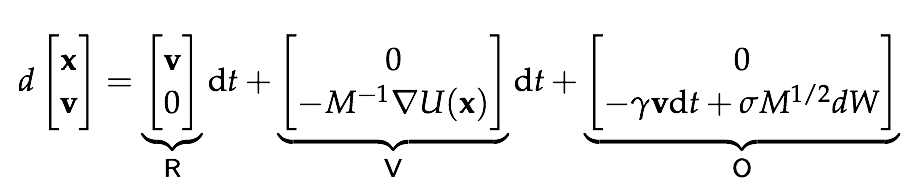

High-quality Langevin integrators are based on symmetric Trotter splittings of the Langevin operator. 
Different splittings of the Langevin propagator result in inequivalent update equations:

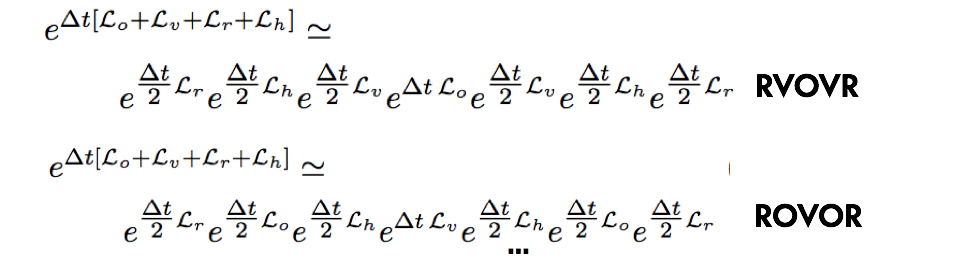

We can use [`openmmtools.integrators.LangevinIntegrator`](http://openmmtools.readthedocs.io/en/latest/api/generated/openmmtools.integrators.LangevinIntegrator.html#openmmtools.integrators.LangevinIntegrator) to automatically construct integrators that appropriately respect constraints.

For example, the OVRVO splitting would result in the following equations: 
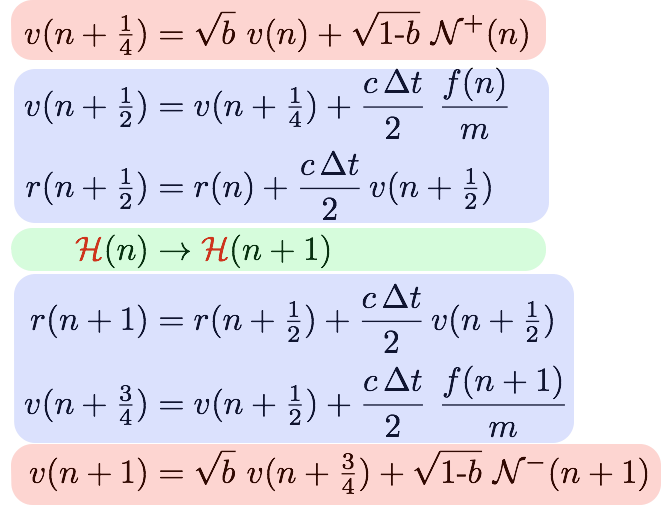

To generate an integrator with the  `VRORV` (BAOAB) splitting championed by [Leimkuhler and Matthews](http://dx.doi.org/10.1063/1.4802990), which has minimal configurational error even close to the stability limit, we simply specify this in the `splitting` string:

In [14]:
# Construct an integrator with the VRORV (BAOAB) splitting
from openmmtools import integrators
integrator = integrators.LangevinIntegrator(temperature=temperature, collision_rate=collision_rate, timestep=timestep,
                                           splitting='V R O R V')
simulation = app.Simulation(topology, system, integrator)
simulation.context.setPositions(positions)
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(temperature)
reportInterval = 100
simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, potentialEnergy=True, temperature=True))
simulation.step(1000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,-67.16098641697317,331.39432585096176
200,-56.77709147334099,330.5416736713131
300,-68.85795614868402,293.40220303789624
400,-67.32519708503969,359.62986949438505
500,-75.15428447266459,352.7438799988138
600,-69.15727468896512,313.61209281851245
700,-51.05764958751388,292.25541374423835
800,-62.27562237903476,298.58983317820787
900,-69.62062949687243,273.3599649350594
1000,-62.73300904035568,356.77270203019003


We can also Metropolize the integrator by inserting `{` and `}` characters where we want to Metropolize away any shadow work. For GHMC with a velocity Verlet (`V R V`) core, we can use:

In [15]:
# Create GHMC integrator based on OVRVO with inner velocity Verlet step Metropolized
integrator = integrators.LangevinIntegrator(temperature=temperature, collision_rate=collision_rate, timestep=timestep,
                                           splitting='O { V R V } O')

In [16]:
simulation = app.Simulation(topology, system, integrator)
simulation.context.setPositions(positions)
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(temperature)
reportInterval = 100
simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, potentialEnergy=True, temperature=True))
simulation.step(1000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,-50.94500440172851,316.5890885907146
200,-70.86862775118789,425.7851351833933
300,-74.25950151728466,453.4474461101337
400,-64.15730081126094,307.977283584025
500,-56.92715934396256,322.7432617799971
600,-50.704172395169735,228.08857827861158
700,-69.33136096945964,361.78764266595925
800,-76.94631380029023,327.69454587616735
900,-61.15952996502165,241.43007497285038
1000,-50.48465806245804,391.5968234677794


In [17]:
# We can even pretty-print LangevinIntegrator to inspect what it does
integrator.pretty_print()

step      0 : allow forces to update the context state
step      1 : if(has_kT_changed = 1):
step      2 :    sigma <- sqrt(kT/m)
step      3 :    has_kT_changed <- 0
step      4 : end
step      5 : v <- (a * v) + (b * sigma * gaussian)
step      6 : constrain velocities
step      7 : xold <- x
step      8 : vold <- v
step      9 : old_ke <- sum(0.5 * m * v * v)
step     10 : v <- v + (dt / 2) * f / m
step     11 : constrain velocities
step     12 : new_ke <- sum(0.5 * m * v * v)
step     13 : shadow_work <- shadow_work + (new_ke - old_ke)
step     14 : old_pe <- energy
step     15 : old_ke <- sum(0.5 * m * v * v)
step     16 : x <- x + ((dt / 1) * v)
step     17 : x1 <- x
step     18 : constrain positions
step     19 : v <- v + ((x - x1) / (dt / 1))
step     20 : constrain velocities
step     21 : new_pe <- energy
step     22 : new_ke <- sum(0.5 * m * v * v)
step     23 : shadow_work <- shadow_work + (new_ke + new_pe) - (old_ke + old_pe)
step     24 : old_ke <- sum(0.5 * m * v * v)
st

We can introduce multiple-timestepping by using [force groups](http://docs.openmm.org/7.1.0/userguide/theory.html#force-groups). For example, let's move the `NonbondedForce` to force group 1 and leave all other valence forces in force group 0:

In [18]:
for force in system.getForces():
    if force.__class__.__name__ in ['NonbondedForce']:
        force.setForceGroup(1)
    else:
        force.setForceGroup(0)
        
# Create multiple-timestep integrator version of OVRVO
integrator = integrators.LangevinIntegrator(temperature=temperature, collision_rate=collision_rate, timestep=timestep,
                                           splitting='O V1 V0 V0 R V0 V0 V1 O')        

In [19]:
simulation = app.Simulation(topology, system, integrator)
simulation.context.setPositions(positions)
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(temperature)
reportInterval = 100
simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, potentialEnergy=True, temperature=True))
simulation.step(1000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,-71.78612236864865,287.89150426416455
200,-28.55955516709946,304.3825782817174
300,-32.27793036978983,293.5305956514006
400,-54.082260109484196,282.3200457012227
500,-41.46222233248409,232.26141018645774
600,-79.86386944167316,244.18488459256298
700,-56.59906441566909,349.993730368857
800,-69.21101092477329,352.3312100179651
900,-63.39392724260688,326.8612533450796
1000,-56.1127566841169,326.8732721603572
